# 540.432 PK: Week 6 (Metabolism)
Team Members: *Alejandro Soto Franco, Callie Jones, Daniel Labbe, and Samuel Bernstein*

This week, we are tasked with demonstrating models of metabolism and the effects of different types of metabolic processes.

Consider a two-compartment model with a central compartment (denoted by $C$) and a peripheral compartment (denoted by $P$). Let $C_C$ be the concentration of drug in the central compartment, $C_P$ the concentration of drug in the peripheral compartment, and $C_M$ the concentration of metabolite. The rates of change of drug concentration in these compartments are governed by the following differential equations:

- $\frac{dC_C}{dt} = -k_{10}C_C - k_{12}C_C + k_{21}C_P - k_{met}C_C + \frac{R_{a}}{V_C}$,
- $\frac{dC_P}{dt} = k_{12}C_C - k_{21}C_P$,
- $\frac{dC_M}{dt} = \frac{k_{met}C_C}{V_C} - k_{elim}C_M$.

Here:

- $R_{a}$ is the rate of absorption (mass/time) into the central compartment (zero for intravenous administration).
- $V_C$ and $V_P$ are the volumes of the central and peripheral compartments.
- $V_M$ is the volume of distribution for the metabolite.
- $k_{10}$ is the first-order elimination rate constant from the central compartment.
- $k_{12}$ and $k_{21}$ are the rate constants for distribution between the central and peripheral compartments.
- $k_{met}$ is the first-order rate constant for metabolism of the drug in the central compartment.
- $k_{elim}$ is the first-order elimination rate constant for the metabolite.
- $\frac{R_{a}}{V_C}$ represents the absorption rate divided by the volume.
- $\frac{k_{met}C_C}{V_C}$ represents the rate of drug metabolism divided by the volume of the central compartment.

Metabolism typically involves Phase I (biochemical modification) and Phase II (conjugation) reactions. In this model, $k_{met}$ represents the overall metabolism rate constant, combining both phases.$k_{met}C_C$ represents the rate of drug metabolism, and $k_{elim}C_M$ represents the rate of metabolite elimination. We assume that metabolism directly translates the parent compound into a single metabolite type and that the metabolite is eliminated from the body without further metabolism.

## 6A: Model Diagram

Below, we have provided a simple sketch of the model.

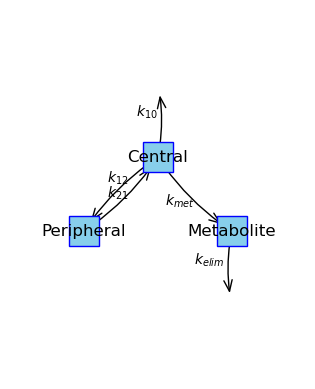

In [15]:
## ASFPKD 6A: Plotting the two-compartment model

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

# Create the directed graph
G = nx.DiGraph()
G.add_nodes_from(['Central', 'Peripheral', 'Metabolite'])
G.add_nodes_from(['Elim_Central', 'Elim_Metabolite'])

# Define edges
G.add_edge('Central', 'Peripheral', label='$k_{12}$')
G.add_edge('Peripheral', 'Central', label='$k_{21}$')
G.add_edge('Central', 'Metabolite', label='$k_{met}$')
G.add_edge('Central', 'Elim_Central', label='$k_{10}$')
G.add_edge('Metabolite', 'Elim_Metabolite', label='$k_{elim}$')

# Position the nodes manually
pos = {
    'Central': (1, 1.5),
    'Peripheral': (0.5, 1),
    'Metabolite': (1.5, 1),
    'Elim_Central': (1, 2),
    'Elim_Metabolite': (1.5, 0.5)
}

# Create a figure and axes
fig, ax = plt.subplots()

# Draw the edges
nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle='arc3,rad=0.1', arrows=True, arrowstyle='->,head_width=0.3,head_length=0.8')

# Draw the nodes
for node, (x, y) in pos.items():
    if node in ['Central', 'Peripheral', 'Metabolite']:  # Only draw the main nodes
        rect = patches.Rectangle((x-0.1, y-0.1), 0.2, 0.2, linewidth=1, edgecolor='blue', facecolor='skyblue')
        ax.add_patch(rect)
        plt.text(x, y, node, ha='center', va='center', fontsize=12, color='black')

# Draw edge labels with transparent background and no border
edge_labels = nx.get_edge_attributes(G, 'label')
transparent_bbox = dict(boxstyle="round,pad=0.3", ec=(1., 1., 1., 0.), fc=(1., 1., 1., 0.),)  # transparent bounding box with no edge color

# Tuning label offsets
offsets = {
    '$k_{12}$': (0.05, 0.05),
    '$k_{21}$': (0.05, -0.05),
    '$k_{met}$': (0, -0.1),
    '$k_{elim}$': (-0.05, 0)
}

for (node1, node2), label in edge_labels.items():
    position = pos[node1][0] / 2 + pos[node2][0] / 2, pos[node1][1] / 2 + pos[node2][1] / 2
    if label in offsets:
        offset_x, offset_y = offsets[label]
        position = (position[0] + offset_x, position[1] + offset_y)

    plt.text(position[0], position[1], label, bbox=transparent_bbox, fontsize=10, ha='right', va='bottom')

plt.xlim(0, 2)
plt.ylim(0, 2.5)
ax.set_aspect('equal')
plt.axis('off')
plt.show()


## 6B: Modeling metabolism of a hypothetical drug
We'll use the scipy.integrate.solve_ivp function to solve the system of ordinary differential equations (ODEs). The model parameters are arbitrary.

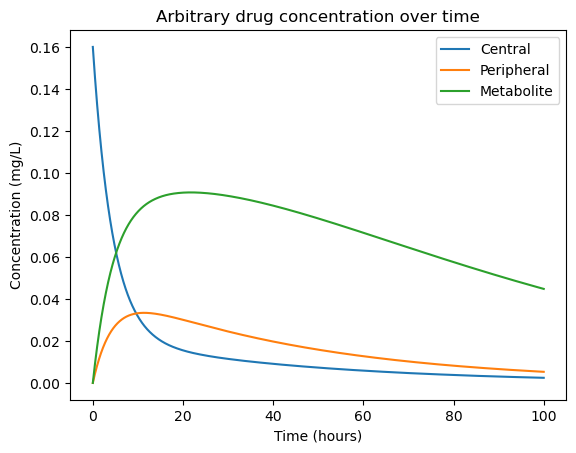

In [22]:
## ASFPKD 6B: Modeling metabolism of a hypothetical drug

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

kCP = 0.1  # Rate of transfer from Central to Peripheral
kPC = 0.05  # Rate of transfer from Peripheral to Central
kmet = 0.08  # Rate of metabolism
k10 = 0.03  # Rate of elimination from Central
kelim = 0.02  # Rate of elimination from Metabolite
VC = 25.0  # Volume of distribution of the Central compartment
VP = 32.0  # Volume of distribution of the Peripheral compartment
VM = 20.0  # Volume of distribution of the Metabolite compartment
Dose = 100.0  # Total drug dose

# Define the system of ODEs
def model(t, y):
    CC, CP, CM = y
    dCCdt = kPC * CP * (VP / VC) - (kCP + kelim + kmet) * CC
    dCPdt = kCP * CC * (VC / VP) - kPC * CP
    dCMdt = kmet * CC * (VC / VM) - kelim * CM
    return [dCCdt, dCPdt, dCMdt]

# Initial conditions: Drug is administered into the Central compartment intravenously
y0 = [Dose/VC, 0, 0]

# Time interval (in hours, for instance)
t = np.linspace(0, 100, 7500)

# Solve the ODE
sol = solve_ivp(model, [t[0], t[-1]], y0, t_eval=t)

# Convert amounts to concentrations by dividing by the respective volume of distribution
C1 = sol.y[0] / VC
C2 = sol.y[1] / VP
C3 = sol.y[2] / VM

# Plot the results
plt.figure()
plt.plot(sol.t, C1, label='Central')
plt.plot(sol.t, C2, label='Peripheral')
plt.plot(sol.t, C3, label='Metabolite')
plt.title('Arbitrary drug concentration over time')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.legend()
plt.show()
